# 4.1 - evaluate modified T5 model

In the previous notebook I have modified the T5 model approach we have reviewed in the lab.

In this notebook I will evaluate the modified model in the same way I did with cond BERT to find the rate of toxicity left after transformation of sentences.

## Load model to evaluate toxicity

In [1]:
from transformers import pipeline

# load metrics
import evaluate

# Load the BLUE metric
metric = evaluate.load("sacrebleu")

# load toxicity rate metric
toxicity_rater = pipeline("text-classification", model="martin-ha/toxic-comment-model")

/home/leo/github.com/lvjonok/f23-pmldl/f23-pmldl-assignment1/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model to be evaluated

In [2]:
# Necessary inputs
import warnings
import argparse
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np

warnings.filterwarnings("ignore")


def translate(model, inference_request, tokenizer):
    """
    translate is helper function which allows easier inference of model

    Args:
        model (transformers.modeling_utils.PreTrainedModel): model to use for inference
        inference_request (str): input string to transform
        tokenizer (transformers.tokenization_utils.PreTrainedTokenizer): tokenizer to use for inference
    """
    prefix = "paraphrase toxic sentences:"
    input_ids = tokenizer(prefix + inference_request, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids)
    return tokenizer.decode(outputs[0], skip_special_tokens=True, temperature=0)


# load model
model = AutoModelForSeq2SeqLM.from_pretrained("./../models/best")

# get tokenizer from model
tokenizer = AutoTokenizer.from_pretrained("./../models/best")

## Load dataset for evaluation

In [3]:
import pandas as pd

# load validation dataset
df = pd.read_csv("../data/interim/val.csv", index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
Unnamed: 0,,,,,,
391689,"You're smaller than I thought you'd be, which ...","you're shorter than I expected, which is odd, ...",0.721598,0.064748,0.998819,0.028113
444152,I bet it's your favorite secret jerk-off movie.,I bet there's a secret joke in that movie.,0.741154,0.104167,0.990315,0.000071
542359,Your fucking gangster brother Michael!,your Nigerian brother Michael!,0.808982,0.205128,0.999699,0.000110
215791,"McMurphy... ...get your ass over here,and brin...","McMurphy, come here and take Dracula with you.",0.756882,0.287879,0.999087,0.018837
308611,Alexis injected it directly into the body of a...,Alexis injected her directly into the body.,0.895725,0.200000,0.947276,0.015108


In [4]:
def evaluate(sentence):
    """
    evaluate is helper function which computes bleu score and toxicity rate
    after sentence transformation
    """

    result = translate(model, sentence, tokenizer)

    # calculate scores
    bleu_score = metric.compute(predictions=[result], references=[[sentence]])["score"]

    # evaluate toxicity
    toxicity = toxicity_rater(result)[0]

    return {
        "sentence": result,
        "bleu_score": bleu_score,
        "toxicity": toxicity,
        "rate": toxicity["score"] * (-1 if toxicity["label"] == "toxic" else 1),
    }


evaluate(df["translation"].iat[0])

{'sentence': "you're shorter than I expected, which is odd, because you gave your instructor a",
 'bleu_score': 48.55129058570216,
 'toxicity': {'label': 'non-toxic', 'score': 0.9938268065452576},
 'rate': 0.9938268065452576}

In [5]:
evaluate("I bet it's bullshit favorite secret jerk-off movie.")

{'sentence': "I'm betting it's a favorite movie.",
 'bleu_score': 11.737849637633069,
 'toxicity': {'label': 'non-toxic', 'score': 0.9991325736045837},
 'rate': 0.9991325736045837}

In [6]:
from tqdm import tqdm

history = []

for sentence in tqdm(df.sample(500)["reference"]):
    history.append(evaluate(sentence))

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [04:32<00:00,  1.83it/s]


# Analysis:

As compared to the cond BERT approach I have presented in `3.0-evaluate-bert`, the T5 model is much more effective in reducing the toxicity of the sentences.

However, rating the BLEU score it is less effective in preserving the meaning of the sentences, but I believe that this score remained high in cond BERT because of words replacement, whereas T5 model can paraphrase and change the structure of the sentence.


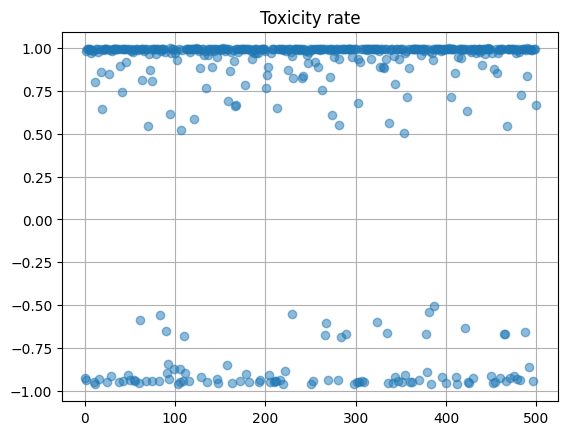

In [7]:
import matplotlib.pyplot as plt

plt.title("Toxicity rate")
plt.plot([h["rate"] for h in history], marker="o", linestyle="None", alpha=0.5)
plt.grid()

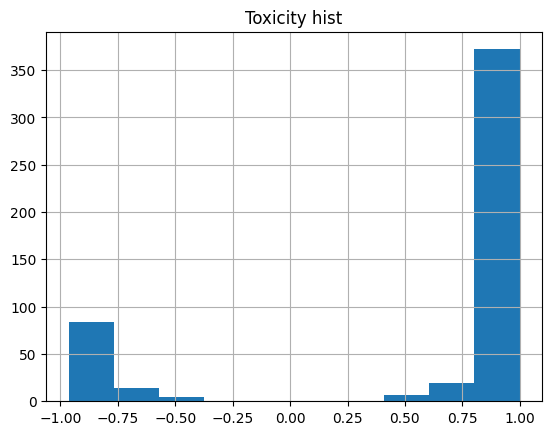

In [8]:
plt.title("Toxicity hist")
plt.hist([h["rate"] for h in history])
plt.grid()

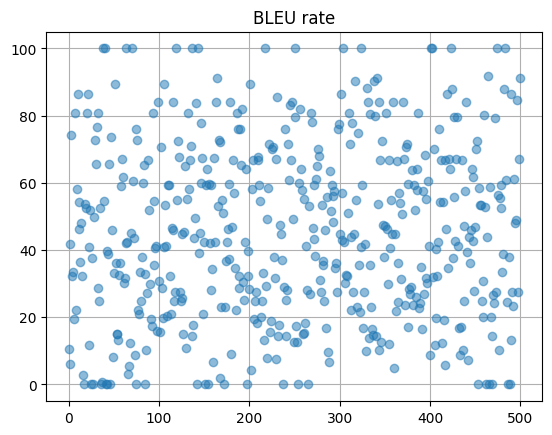

In [9]:
import matplotlib.pyplot as plt

plt.title("BLEU rate")
plt.plot([h["bleu_score"] for h in history], marker="o", linestyle="None", alpha=0.5)
plt.grid()

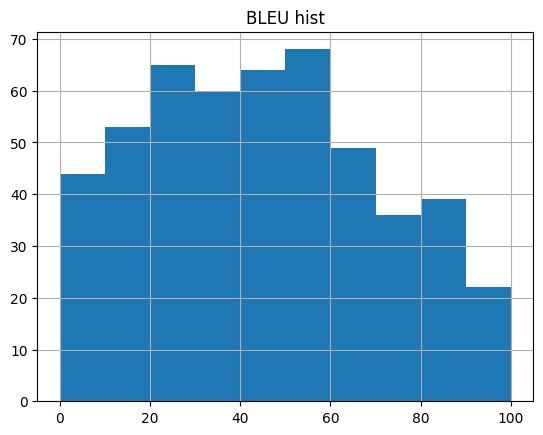

In [10]:
plt.title("BLEU hist")
plt.hist([h["bleu_score"] for h in history])
plt.grid()